In [54]:
# Quick hack to fix local imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Get Input Datasets

In [218]:
import pyrosm
import geopandas
import numpy as np
import rasterio
import rioxarray as rxr
from matplotlib import pyplot as plt
from shapely.geometry import mapping
from rasterio.crs import CRS

In [228]:
OUT_CRS = CRS.from_epsg(27700)  # https://epsg.io/27700

In [156]:
# # Read all boundaries using the default settings
# boundaries = osm.get_boundaries()

# # pick a small subset for testing
# boundary = osm.get_boundaries(name="London Borough of Tower Hamlets")
# boundary.plot()

import geopandas as gpd
from shapely.geometry import box

bbox = box(-0.04, 51.48, 0.011, 51.52)  # a random box around a part of Tower Hamlets and Canary Wharf
boundary = geopandas.GeoDataFrame({'geometry': bbox}, index=[0])

In [57]:
# Get London's OpenStreetMap data
fp = pyrosm.get_data("London", update=True)
# Initialize the OSM object 
osm = pyrosm.OSM(fp)

Downloaded Protobuf data 'London.osm.pbf' (66.95 MB) to:
'/tmp/pyrosm/London.osm.pbf'


In [157]:
uk_wp = rxr.open_rasterio('../data/gbr_ppp_2020_UNadj_constrained.tif', masked=True).squeeze()
print(uk_wp.rio.crs)  # make sure the crs is EPSG:4326 (WGS84) to match the unprojected OSM boundary
wp_clipped = uk_wp.rio.clip(boundary.geometry.apply(mapping))

EPSG:4326


In [158]:
# Get the shapely geometry from GeoDataFrame
bbox_geom = boundary['geometry'].values[0]

# Initialise with bounding box
osm = pyrosm.OSM(fp, bounding_box=bbox_geom)

In [159]:
# get all residential buildings as well as ones without a specific tag
residential_filter = {"building": ["residential", "apartments", "flats", "house", "yes"]}
residential_buildings = osm.get_buildings(custom_filter=residential_filter)

In [160]:
# crudely get all places that might be considered workplaces
pois_filter = {"shop": True,"amenity": True, "leisure": True, "tourism": True}
pois = osm.get_pois(custom_filter=pois_filter)
office_filter = {"office": True}
offices = osm.get_data_by_custom_criteria(custom_filter=office_filter)
office_building_filter = {"building": ["office", "offices"]}
office_buildings = osm.get_buildings(custom_filter=office_building_filter)

In [161]:
# combine the locations of all of the crude workplaces
trimmed_households = residential_buildings[['geometry']]
trimmed_workplaces = pois[['geometry']]
trimmed_offices = offices[['geometry']]
trimmed_office_buildings = office_buildings[['geometry']]
trimmed_work = trimmed_workplaces.append(trimmed_offices).append(trimmed_office_buildings)
trimmed_work = trimmed_work.reset_index()
trimmed_work['geometry'] = trimmed_work.geometry.centroid

<ipython-input-161-fa8dc12bfe30>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trimmed_work['geometry'] = trimmed_work.geometry.centroid


<AxesSubplot:title={'center':'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

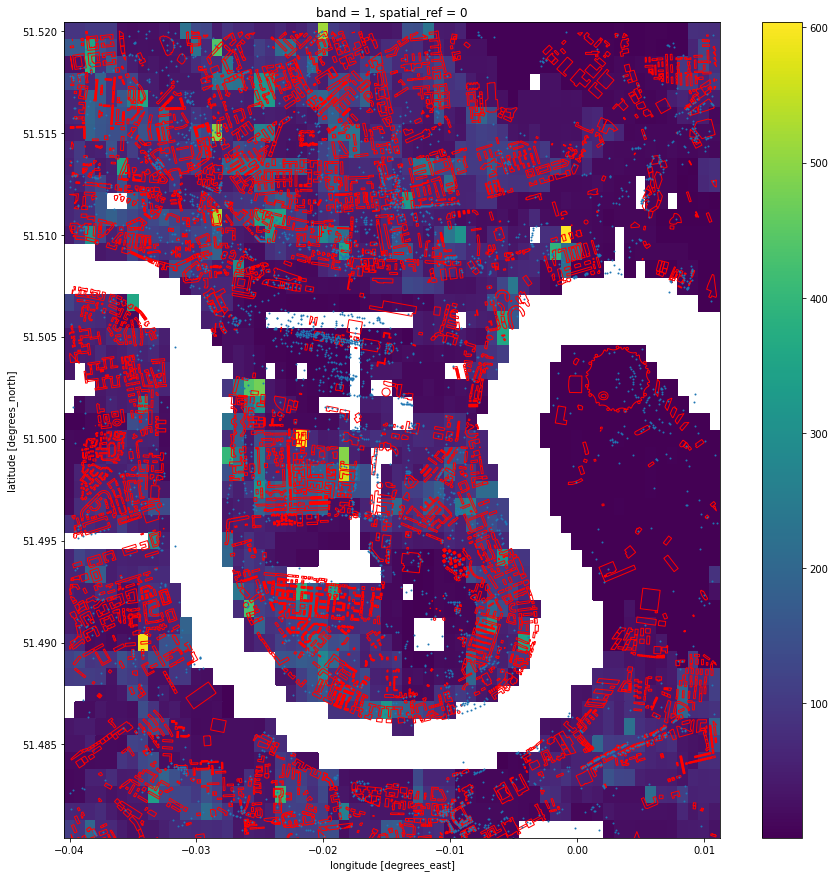

In [167]:
fig, ax = plt.subplots(figsize=(15, 15))
wp_clipped.plot(ax=ax)
residential_buildings.plot(ax=ax, facecolor='none', edgecolor='r');
trimmed_work.plot(ax=ax, markersize=1)

#### Build Model

In [401]:
import generated.OutbreakSim as gen

import random
from enum import IntEnum

import flatbuffers

import pandas as pd
from scipy.spatial import cKDTree
import scipy.stats as stats

from geopy import distance

In [84]:
# TODO, nonsense atm
AGENT_SIZE = 32  # in bytes
WORKPLACE_SIZE = 8  # in bytes
HOUSEHOLD_SIZE = 8  # in bytes
CONTAINER_SIZE = 8  # in bytes

initial_buffer_size = (int(wp_clipped.sum())
                       * AGENT_SIZE + len(trimmed_households) 
                       * HOUSEHOLD_SIZE + len(trimmed_work) 
                       * WORKPLACE_SIZE)
print(initial_buffer_size)

821184


In [85]:
builder = flatbuffers.Builder(initial_buffer_size)

In [289]:
# inspired by https://gis.stackexchange.com/a/301935
def cKDQueryRadius(gdA_in, gdB_in, radius=300, reproject=True):
    gdA = gdA_in.copy()
    gdB = gdB_in.copy()
    if reproject:
        in_crs = gdA.crs
        gdA = gdA.to_crs(OUT_CRS)
        gdB = gdB.to_crs(OUT_CRS)
        
    nA = np.array(list(gdA.geometry.centroid.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.centroid.apply(lambda x: (x.x, x.y))))
    
    btree = cKDTree(nB)
    elements_in_radius = btree.query_ball_point(nA, r=radius)
    
    gdf = pd.concat(
        [gdA.reset_index(drop=True),
        pd.Series(elements_in_radius, name='Elements in Radius')], axis=1
    )
    if reproject:
        gdf = gdf.to_crs(gdA_in.crs)
    return gdf

In [327]:
nx, ny = wp_clipped.sizes['x'], wp_clipped.sizes['y']
x, y = wp_clipped.rio.transform() * np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5)

# GeoDataFrame of centres of raster cells, indexed by their respective ravelled index
raster_coords = geopandas.GeoDataFrame({'ravelled_index': np.arange(x.size)}, geometry=geopandas.points_from_xy(x.ravel(), y.ravel()), crs="EPSG:4326")
residences_in_radius = cKDQueryRadius(raster_coords, residential_buildings)

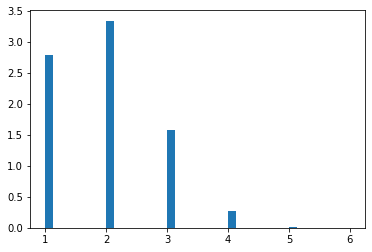

In [368]:
lower, upper = 1, 8
mu, sigma = 2.2, 0.98

household_size_dist = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)  # TODO Replace according to research https://www.statista.com/statistics/281627/households-in-the-united-kingdom-uk-by-size/
fig, ax = plt.subplots(1, 1)
ax.hist(X.rvs(100_000).astype(int), density=True, bins=40)
plt.show()
del fig, ax, 

In [390]:
class Person():
    def __init__(self, uid, household_uid):
        self.uid = uid
        self.household_uid = household_uid

In [391]:
class Household():
    def __init__(self, uid):
        self.uid = uid
        self.inhabitants = 0
        self.max_inhabitants = household_size_dist.rvs(1)[0]

        
class ResidenceType(IntEnum):
    HOUSE = 0
    SMALL_FLATS = 1  # Perhaps a few floors or flats in one building
    LARGE_FLATS = 2  # Generally high-rise, shared lifts, etc.


residence_params = {
    'max_household_capacity': 7,
    ResidenceType.HOUSE: {
        'max_households': 2
    },
    ResidenceType.SMALL_FLATS: {
        'max_households': 10
    },
    ResidenceType.LARGE_FLATS: {
        'max_households': 150
    }
}

residential_buildings['residence_type'] = ResidenceType.HOUSE
residential_buildings.loc[residential_buildings['building'].isin(['apartments', 'flats']), 'residence_type'] = ResidenceType.SMALL_FLATS

In [414]:
%%time
from collections import defaultdict

people = []
households = []
residences_to_households = defaultdict(lambda: [])

for row in range(wp_clipped.shape[0]):
    for col in range(wp_clipped.shape[1]):
        index = (row, col)
        people_at_tile = wp_clipped[row, col]
        
        if np.isnan(people_at_tile):
            continue
        
        local_residences_indices = residences_in_radius.loc[np.ravel_multi_index(index, wp_clipped.shape), 'Elements in Radius']
        
        for _ in range(int(people_at_tile)):
            shuffled_indices = np.random.permutation(local_residences_indices)

            chosen_household = None

            for residence_index in shuffled_indices:
                households_at_residence = [households[household_uid] for household_uid in residences_to_households[residence_index]]
                possible_households = [household for household in households_at_residence if household.inhabitants < household.max_inhabitants]

                if len(possible_households) != 0:
                    chosen_household = random.choice(possible_households)
                    chosen_household.inhabitants += 1
                    break
                else:
                    building_type = residential_buildings.loc[residence_index, 'residence_type']
                    if len(households_at_residence) < residence_params[building_type]['max_households']:
                        new_household_uid = len(households)
                        chosen_household = Household(uid=new_household_uid)
                        
                        households.append(chosen_household)

                        chosen_household.inhabitants += 1

                        residences_to_households[residence_index].append(new_household_uid)
            else:  # failed to find an available household, or residence to make a new household in, so upgrade a residence 
                smaller_residences_indices = [residence_index for residence_index in local_residences_indices 
                                              if residential_buildings.loc[residence_index, 'residence_type'] != ResidenceType.LARGE_FLATS]
                
                if len(smaller_residences_indices) != 0:
                    chosen_residence_index = random.choice(smaller_residences_indices)
                    residential_buildings.loc[chosen_residence_index, 'residence_type'] = ResidenceType(residential_buildings.loc[chosen_residence_index, 'residence_type'] + 1)
                    
                    new_household_uid = len(households)

                    chosen_household = Household(uid=new_household_uid)
                    households.append(chosen_household)

                    chosen_household.inhabitants += 1

                    residences_to_households[chosen_residence_index].append(new_household_uid)
                else:
                    print("bugger")
                    continue
#                     raise Exception("Bugger gotta deal with this")
            people.append(Person(len(people), chosen_household.uid))
                

bugger
bugger
bugger
CPU times: user 45.1 s, sys: 1.33 s, total: 46.4 s
Wall time: 45.3 s


In [416]:
print(len(households))
print(len(people))

81240
155939
